In [10]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from braindecode.models import ShallowFBCSPNet
from braindecode.util import set_random_seeds
from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler
import matplotlib.pyplot as plt
from yuriy_preprocess import get_yuriy_data

# Set random seeds for reproducibility
set_random_seeds(seed=20200220, cuda=True)


In [11]:
# Load the data
print("Loading Yuriy's data...")
X, Y, meta_data = get_yuriy_data(samples_around=300)

print(f"Data shape: {X.shape}")
print(f"Labels shape: {Y.shape}")
print(f"Unique labels: {np.unique(Y)}")
print(f"Number of channels: {len(meta_data['channel_names'])}")
print(f"Sampling frequency: {meta_data['sampFreq']} Hz")
print(f"Channel names: {meta_data['channel_names'][:10]}...")  # Show first 10 channels


Loading Yuriy's data...
Data shape: (1388, 600, 19)
Labels shape: (1388,)
Unique labels: [1 2]
Number of channels: 19
Sampling frequency: 200 Hz
Channel names: ['Fp1' 'Fp2' 'F3' 'F4' 'C3' 'C4' 'P3' 'P4' 'O1' 'O2']...


In [12]:
# Prepare the data for braindecode
# Convert labels to 0-based indexing (braindecode expects 0-based)
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

print(f"Original labels: {np.unique(Y)}")
print(f"Encoded labels: {np.unique(Y_encoded)}")

# Convert to torch tensors and ensure correct data types
X_tensor = torch.from_numpy(X).float()
Y_tensor = torch.from_numpy(Y_encoded).long()

# Transform data from (n_trials, n_timepoints, n_channels) to (n_trials, n_channels, n_timepoints)
# Braindecode expects shape (n_trials, n_channels, n_timepoints)
print(f"Original X tensor shape: {X_tensor.shape}")
X_tensor = X_tensor.permute(0, 2, 1)  # Change from (trials, time, channels) to (trials, channels, time)
print(f"Transformed X tensor shape: {X_tensor.shape}")
print(f"Y tensor shape: {Y_tensor.shape}")

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(
    X_tensor, Y_tensor, test_size=0.2, random_state=42, stratify=Y_tensor
)

print(f"Training set: {X_train.shape}, {Y_train.shape}")
print(f"Test set: {X_test.shape}, {Y_test.shape}")

# Verify the final data shape for braindecode
print(f"\nFinal verification:")
print(f"Expected format: (n_trials, n_channels, n_timepoints)")
print(f"X_train shape: {X_train.shape} -> (trials={X_train.shape[0]}, channels={X_train.shape[1]}, timepoints={X_train.shape[2]})")
print(f"X_test shape: {X_test.shape} -> (trials={X_test.shape[0]}, channels={X_test.shape[1]}, timepoints={X_test.shape[2]})")


Original labels: [1 2]
Encoded labels: [0 1]
Original X tensor shape: torch.Size([1388, 600, 19])
Transformed X tensor shape: torch.Size([1388, 19, 600])
Y tensor shape: torch.Size([1388])
Training set: torch.Size([1110, 19, 600]), torch.Size([1110])
Test set: torch.Size([278, 19, 600]), torch.Size([278])

Final verification:
Expected format: (n_trials, n_channels, n_timepoints)
X_train shape: torch.Size([1110, 19, 600]) -> (trials=1110, channels=19, timepoints=600)
X_test shape: torch.Size([278, 19, 600]) -> (trials=278, channels=19, timepoints=600)


In [13]:
# Create the ShallowFBCSPNet model
n_outputs = len(np.unique(Y_encoded))
# After transpose: X_tensor shape is (n_trials, n_channels, n_timepoints)
n_chans = X_tensor.shape[1]  # Number of channels (after transpose)
n_times = X_tensor.shape[2]  # Number of time samples (after transpose)
sfreq = meta_data['sampFreq']  # Sampling frequency

print(f"Model parameters:")
print(f"  Number of classes: {n_outputs}")
print(f"  Number of channels: {n_chans}")
print(f"  Input window samples: {n_times}")
print(f"  Sampling frequency: {sfreq}")

# Create the model
model = ShallowFBCSPNet(
    n_chans=n_chans,
    n_outputs=n_outputs,
    n_times=n_times,
    final_conv_length="auto",
)

print(f"Model created: {model}")

# Check if CUDA is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Model parameters:
  Number of classes: 2
  Number of channels: 19
  Input window samples: 600
  Sampling frequency: 200
Model created: ============================================================================================================================================
Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
ShallowFBCSPNet (ShallowFBCSPNet)        [1, 19, 600]              [1, 2]                    --                        --
├─Ensure4d (ensuredims): 1-1             [1, 19, 600]              [1, 19, 600, 1]           --                        --
├─Rearrange (dimshuffle): 1-2            [1, 19, 600, 1]           [1, 1, 600, 19]           --                        --
├─CombinedConv (conv_time_spat): 1-3     [1, 1, 600, 19]           [1, 40, 576, 1]           31,440                    --
├─BatchNorm2d (bnorm): 1-4               [1, 40, 576, 1]           [1, 40, 576, 1]           80         

/Users/alejandro/watolink/Models/.venv/lib/python3.11/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [14]:
# Set up the training using skorch
clf = NeuralNetClassifier(
    model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.AdamW,
    optimizer__lr=0.0625 * 0.01,
    optimizer__weight_decay=0,
    batch_size=32,
    callbacks=[
        LRScheduler(policy="CosineAnnealingLR", T_max=50),
    ],
    max_epochs=50,
    device=device,
    verbose=1,
)

print("Starting training...")

Starting training...


In [15]:
print(f"Starting full training...")
print(f"Training data: {X_train.shape}")
print(f"Labels: {Y_train.shape} with classes {torch.unique(Y_train).tolist()}")

# Train the model
clf.fit(X_train, Y_train)
print("\n✅ Training completed successfully!")

Starting full training...
Training data: torch.Size([1110, 19, 600])
Labels: torch.Size([1110]) with classes [0, 1]
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.9685       0.6757        0.5955  0.0006  0.4765
      2        0.6055       0.7748        0.4767  0.0006  0.4898
      3        0.4231       0.8649        0.3725  0.0006  0.5033
      4        0.2983       0.8649        0.3009  0.0006  0.5186
      5        0.2222       0.8694        0.2632  0.0006  0.5080
      6        0.1853       0.9279        0.2243  0.0006  0.5037
      7        0.1533       0.9324        0.2021  0.0006  0.4960
      8        0.1419       0.9144        0.1997  0.0006  0.5083
      9        0.1074       0.9324        0.1851  0.0006  0.4936
     10        0.0849       0.9369        0.1762  0.0006  0.5006
     11        0.0797       0.9234        0.1767  0.0006  0.5105
     12        0.0661       0.9279     

In [16]:
# Evaluate the model
print("Evaluating model...")

# Training accuracy
train_predictions = clf.predict(X_train)
train_accuracy = np.mean(train_predictions == Y_train.numpy())
print(f"Training Accuracy: {train_accuracy:.4f}")

# Test accuracy
test_predictions = clf.predict(X_test)
test_accuracy = np.mean(test_predictions == Y_test.numpy())
print(f"Test Accuracy: {test_accuracy:.4f}")

# Print predictions vs actual for first 20 test samples
print("\nFirst 20 test predictions vs actual:")
for i in range(min(20, len(Y_test))):
    pred_label = label_encoder.inverse_transform([test_predictions[i]])[0]
    actual_label = label_encoder.inverse_transform([Y_test[i].item()])[0]
    print(f"Sample {i+1}: Predicted={pred_label}, Actual={actual_label}")


Evaluating model...
Training Accuracy: 0.9919
Test Accuracy: 0.9604

First 20 test predictions vs actual:
Sample 1: Predicted=1, Actual=2
Sample 2: Predicted=1, Actual=1
Sample 3: Predicted=1, Actual=1
Sample 4: Predicted=2, Actual=2
Sample 5: Predicted=2, Actual=2
Sample 6: Predicted=2, Actual=2
Sample 7: Predicted=1, Actual=1
Sample 8: Predicted=2, Actual=2
Sample 9: Predicted=1, Actual=1
Sample 10: Predicted=2, Actual=2
Sample 11: Predicted=2, Actual=2
Sample 12: Predicted=1, Actual=1
Sample 13: Predicted=2, Actual=2
Sample 14: Predicted=1, Actual=1
Sample 15: Predicted=2, Actual=2
Sample 16: Predicted=1, Actual=1
Sample 17: Predicted=2, Actual=2
Sample 18: Predicted=2, Actual=2
Sample 19: Predicted=1, Actual=1
Sample 20: Predicted=2, Actual=2


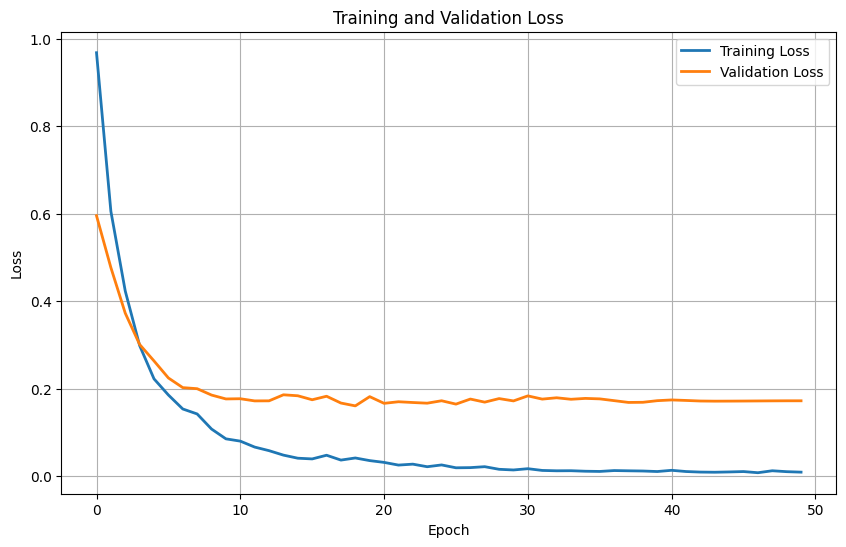

Final training loss: 0.0087
Final validation loss: 0.1720


In [17]:
# Plot training history
train_losses = [hist['train_loss'] for hist in clf.history]
valid_losses = [hist['valid_loss'] for hist in clf.history]

plt.figure(figsize=(10, 6))
plt.plot(train_losses, linewidth=2, label='Training Loss')
plt.plot(valid_losses, linewidth=2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {valid_losses[-1]:.4f}")


Confusion Matrix:
[[133   6]
 [  5 134]]

Classification Report:
              precision    recall  f1-score   support

           1       0.96      0.96      0.96       139
           2       0.96      0.96      0.96       139

    accuracy                           0.96       278
   macro avg       0.96      0.96      0.96       278
weighted avg       0.96      0.96      0.96       278



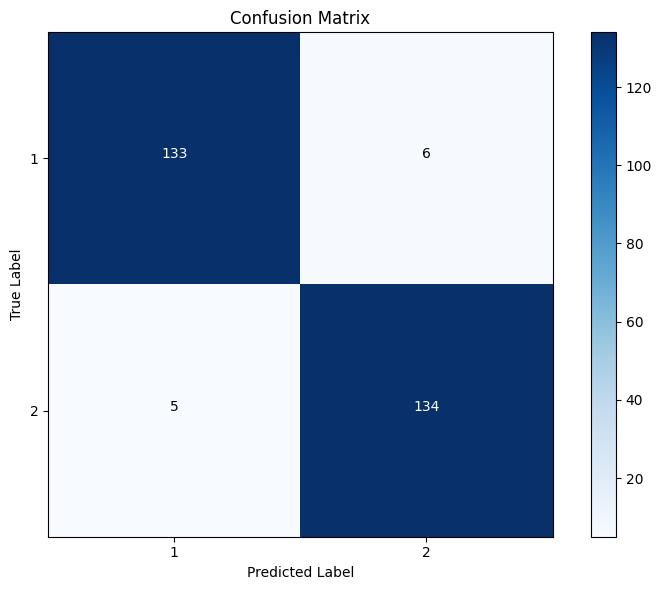

In [18]:
# Confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report

# Get original labels back
test_labels_original = label_encoder.inverse_transform(Y_test.numpy())
pred_labels_original = label_encoder.inverse_transform(test_predictions)

# Confusion matrix
cm = confusion_matrix(test_labels_original, pred_labels_original)
print("Confusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(test_labels_original, pred_labels_original))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(test_labels_original)))
plt.xticks(tick_marks, np.unique(test_labels_original))
plt.yticks(tick_marks, np.unique(test_labels_original))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add numbers to confusion matrix
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()
